In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward as ak
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)

In [3]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:
import sys,os

In [5]:
#find root files in this dir
def find_this_rootfiles(dir):
    filename_list = os.listdir(dir)
    files = []
    for i, filename in enumerate(filename_list):
        if(filename.find(".root")==-1): continue
        files.append(filename)
    return files

def get_hist(array,weights,nbins=50,xmin=None, xmax=None,mergeflowbin=True):
    if xmin is None:
        xmin = ak.min(array)
    if xmax is None:
        xmax = ak.max(array)
    bins  = bh.axis.Regular(nbins, xmin, xmax)
    hist = bh.Histogram(bins)
    hist.fill(array,weight=weights)
    return hist

In [82]:
ori_dir = '/cms/user/guojl/Sample/2L2Q/UL_Legacy/2016/'
samples_inf = {#name path cross Section
                    'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 363.8142],
                    'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',84.014804],
                    'DY_pt250To400':['MC/DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.047],
                    'DY_pt400To650':['MC/DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.392],
                    'DY_pt650ToInf':['MC/DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.03636],
                    'TTJets':['MC/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8',831.76],
                    'TTTo2L2Nu':['MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',1],
                    'WW_TuneCP5':['MC/WW_TuneCP5_13TeV-pythia8',1],
                    'WZTo2Q2L':['MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',6.419],
                    'ZZTo2Q2L':['MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.696],
                    'Signal':'MC/Signal',
                    'test':'MC/test',
                    'Data':['Data/skimed/Data2016UL_noDuplicates.root',1],
                    }

MClists = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650',
              'TTJets',
              'WZTo2Q2L',
              'ZZTo2Q2L']

lumi = {2016: 16.81, 2017: 41.53, 2018: 59.74}
year=2016

bininfo = {'mass2l':[24,60,120]}

In [83]:
#var to draw
nbins, xmin, xmax = bininfo['mass2l'][0], bininfo['mass2l'][1], bininfo['mass2l'][2]

bins  = bh.axis.Regular(nbins, xmin, xmax)
hist_DY = bh.Histogram(bins)
hist_TTjst = bh.Histogram(bins)
hist_VZ = bh.Histogram(bins)

In [84]:
#extract branch and fill hists for MC
for MClist in MClists:
    indir = ori_dir+samples_inf[MClist][0]+'/skimed'
    files = find_this_rootfiles(indir)
    
    sumWeight = 0
    for file in files:
        with uproot.open(f'{indir}/{file}') as f:
            this_sumWeight_h = f['sumWeights'].to_boost()
            this_sumWeight = this_sumWeight_h.sum()
            #print(f'this sum weight = {this_sumWeight}')
            sumWeight += this_sumWeight
            
    #cut='passedfullmerged & particleNetZvsQCD>0.9'
    #ak_arrays = event.arrays(['pt2l','mass2l','EventWeight'],cut,library="ak")
    ak_arrays = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=['pt2l','mass2l','EventWeight','foundZ1LCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD'])
    cut_array = (ak_arrays['foundZ1LCandidate']) & (ak_arrays['pt2l']>100)
    ak_arrays = ak_arrays[cut_array]
    
    weights = (ak_arrays['EventWeight']*lumi[2016]*1000*samples_inf[MClist][1])/sumWeight
    temp_hist = get_hist(ak_arrays['mass2l'],weights,nbins,xmin,xmax)
    
    if MClist.find('DY')!=-1:
        hist_DY+=temp_hist
    if MClist.find('TTJets')!=-1:
        hist_TTjst+=temp_hist
    if MClist.find('WZTo2Q2L')!=-1 or MClist.find('ZZTo2Q2L')!=-1:
        hist_VZ+=temp_hist
MChist_lists = [hist_VZ,hist_TTjst,hist_DY]

#extract branch and fill hists for Data
data_path = ori_dir+samples_inf['Data'][0]
ak_arrays = uproot.lazy([f"{data_path}:passedEvents"],filter_name=['pt2l','mass2l','EventWeight','foundZ1LCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD'])
cut_array = (ak_arrays['foundZ1LCandidate']) & (ak_arrays['pt2l']>100)
ak_arrays = ak_arrays[cut_array]
weights = ak_arrays['EventWeight']
Data_hist = get_hist(ak_arrays['mass2l'],weights,nbins,xmin,xmax)

In [18]:
h = bh.Histogram()
h

Histogram(storage=Double())

In [23]:
color_order = sns.color_palette('Accent', 3)
color_order.reverse()

In [43]:
h=[hist_lists[0][0]+hist_lists[0][1],hist_lists[1][0],hist_lists[2][0]+hist_lists[2][1]+hist_lists[2][2]+hist_lists[2][3]]
h

[Histogram(Regular(28, 40, 140), storage=Double()) # Sum: 3462.552245213883 (3498.916073288885 with flow),
 Histogram(Regular(28, 40, 140), storage=Double()) # Sum: 24487.853026453406 (30045.565183278173 with flow),
 Histogram(Regular(28, 40, 140), storage=Double()) # Sum: 120243.02058190922 (121558.3467242315 with flow)]

[ErrorBarArtists(errorbar=<ErrorbarContainer object of 3 artists>)]

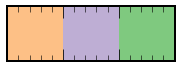

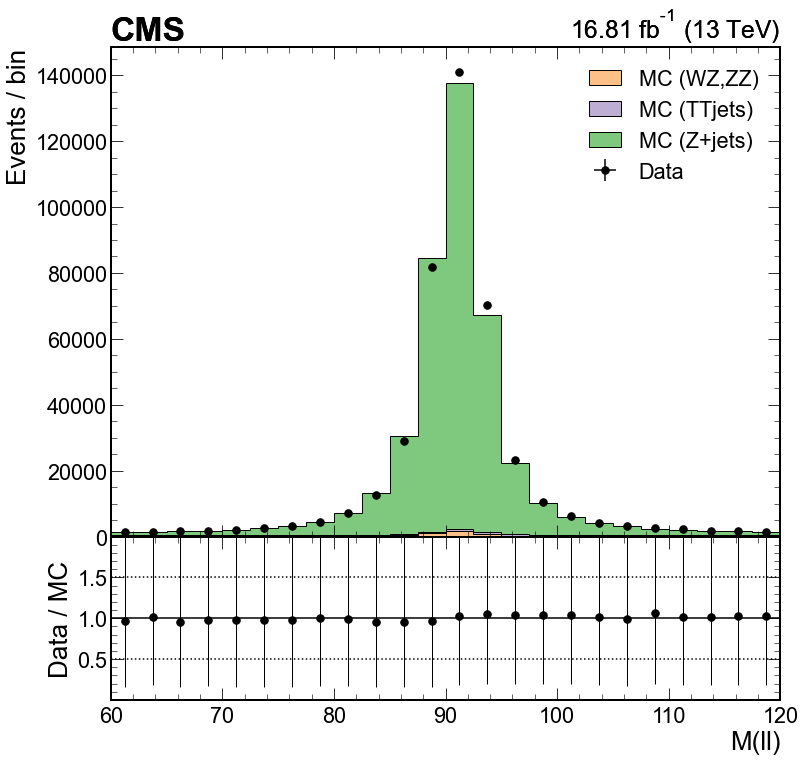

In [85]:
set_sns_color(color_order)
f = plt.figure(figsize=(12,12))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
## Upper histogram panel
ax = f.add_subplot(gs[0])
hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
ax.set_ylabel('Events / bin', ha='right', y=1.0)
#content = hist.values()
hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
#hep.histplot(content, bins=edge, label="MC",histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
hep.histplot(MChist_lists,label=[f'MC ({var})' for var in ['WZ,ZZ','TTjets','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
ax.set_ylabel('Events / bin', ha='right', y=1.0);

#data, data_errh, data_errl = Data_hist.yvalues, Data_hist.yerrorshigh, Data_hist.yerrorslow
hep.histplot(Data_hist, label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()

## Ratio panel
ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
ax1.set_xlabel('M(ll)', ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')

bkg_tot = (hist_DY+hist_TTjst+hist_VZ).values()
data = Data_hist.values()
edge = (Data_hist.axes.edges)[0]
hep.histplot(data/bkg_tot, bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)


In [40]:
bkg_tot = (hist_DY+hist_TTjst+hist_VZ).values()
bkg_tot

array([  569.53683351,   676.25065724,   818.06195352,  1104.04903638,
        1231.50959626,  1259.18148347,  1313.68455901,  1489.00811497,
        1724.57982119,  2029.71215968,  2720.69339514,  4207.20014641,
        9016.60894382, 31694.25104459, 52652.14929093, 14923.33756129,
        4909.16577169,  2895.71669624,  2062.42820482,  1773.56791152,
        1561.60932176,  1386.74734832,  1225.54752151,  1109.06161915,
        1019.49896957,   994.89088487,   912.37903231,   912.99797441])

In [57]:
Data_hist.variances

<bound method Histogram.variances of Histogram(Regular(28, 40, 140), storage=Double()) # Sum: 163638.0 (170222.0 with flow)>

In [73]:
color_order = sns.color_palette('dark', 3)
color_order

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745)]